# Unsupervised Learning Crash Course for Data Science Assessments

**Last Updated:** 25 January 2026

This notebook covers unsupervised learning techniques commonly tested in data science interviews. We focus on clustering algorithms, dimensionality reduction, and anomaly detection methods.

## Table of Contents

1. [Introduction and Setup](#1-introduction-and-setup)
2. [Clustering Overview](#2-clustering-overview)
3. [K-Means Clustering](#3-k-means-clustering)
4. [Hierarchical Clustering](#4-hierarchical-clustering)
5. [DBSCAN](#5-dbscan)
6. [Clustering Evaluation Metrics](#6-clustering-evaluation-metrics)
7. [Dimensionality Reduction Overview](#7-dimensionality-reduction-overview)
8. [Principal Component Analysis (PCA)](#8-principal-component-analysis-pca)
9. [t-SNE](#9-t-sne)
10. [UMAP](#10-umap)
11. [Anomaly Detection](#11-anomaly-detection)
12. [Practice Questions](#12-practice-questions)
13. [Summary](#13-summary)

---

## 1. Introduction and Setup

**Unsupervised learning** finds patterns in data without labelled outcomes. Unlike supervised learning, there's no "correct answer" to learn from.

**Main Categories:**
- **Clustering**: Group similar data points together
- **Dimensionality Reduction**: Reduce features while preserving information
- **Anomaly Detection**: Identify unusual data points

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict

from sklearn.datasets import make_blobs, make_moons, load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score,
    adjusted_rand_score, normalized_mutual_info_score
)
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

plt.style.use('seaborn-v0_8-whitegrid')

print("All imports successful!")

All imports successful!


### Sample Datasets

In [2]:
X_blobs, y_blobs = make_blobs(n_samples=300, centers=4, cluster_std=0.6, random_state=42)
X_moons, y_moons = make_moons(n_samples=300, noise=0.05, random_state=42)

iris = load_iris()
X_iris, y_iris = iris.data, iris.target

print(f"Blobs dataset: {X_blobs.shape}")
print(f"Moons dataset: {X_moons.shape}")
print(f"Iris dataset: {X_iris.shape}")

Blobs dataset: (300, 2)
Moons dataset: (300, 2)
Iris dataset: (150, 4)


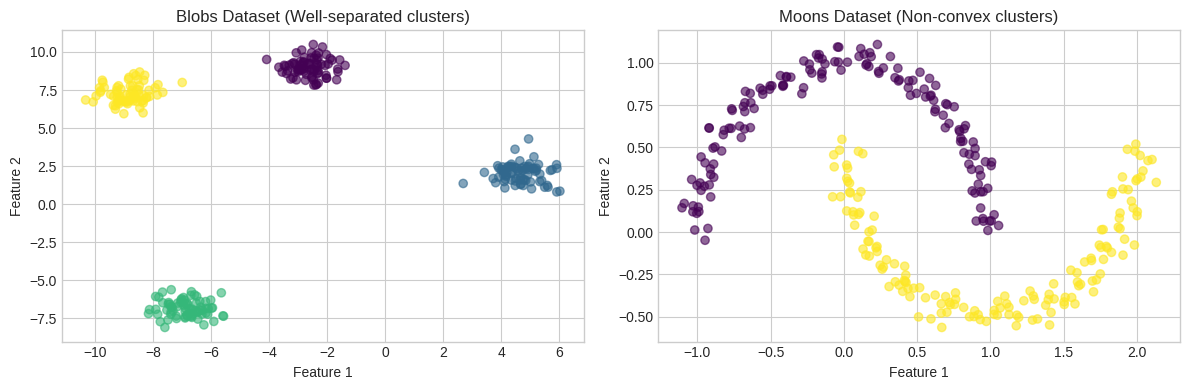

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].scatter(X_blobs[:, 0], X_blobs[:, 1], c=y_blobs, cmap='viridis', alpha=0.6)
axes[0].set_title('Blobs Dataset (Well-separated clusters)')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

axes[1].scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap='viridis', alpha=0.6)
axes[1].set_title('Moons Dataset (Non-convex clusters)')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

---

## 2. Clustering Overview

**Clustering** groups data points such that points within a cluster are more similar to each other than to points in other clusters.

| Algorithm | Cluster Shape | Requires K | Handles Noise | Scalability |
|-----------|--------------|------------|---------------|-------------|
| K-Means | Spherical | Yes | No | Excellent |
| Hierarchical | Any | No* | No | Poor |
| DBSCAN | Any | No | Yes | Good |

*Hierarchical clustering produces a tree; you choose where to cut it.

**When to use each:**
- **K-Means**: Large datasets, spherical clusters, known K
- **Hierarchical**: Small datasets, want to visualise hierarchy
- **DBSCAN**: Unknown K, non-spherical clusters, noisy data

---

## 3. K-Means Clustering

**K-Means** partitions data into K clusters by minimising within-cluster variance (inertia).

**Algorithm:**
1. Initialise K cluster centroids randomly
2. Assign each point to nearest centroid
3. Update centroids as mean of assigned points
4. Repeat until convergence

**Limitations:**
- Must specify K beforehand
- Assumes spherical clusters
- Sensitive to initialisation (use k-means++)
- Sensitive to outliers

In [4]:
def fit_kmeans(
    X: np.ndarray,
    n_clusters: int,
    random_state: int = 42
) -> Tuple[KMeans, np.ndarray]:
    """Fit K-Means clustering model.
    
    Args:
        X: Feature matrix.
        n_clusters: Number of clusters.
        random_state: Random seed for reproducibility.
    
    Returns:
        Tuple of (fitted KMeans model, cluster labels).
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    labels = kmeans.fit_predict(X)
    return kmeans, labels

In [5]:
kmeans_model, kmeans_labels = fit_kmeans(X_blobs, n_clusters=4)

print(f"Cluster centres shape: {kmeans_model.cluster_centers_.shape}")
print(f"Inertia (within-cluster sum of squares): {kmeans_model.inertia_:.2f}")
print(f"Unique labels: {np.unique(kmeans_labels)}")

Cluster centres shape: (4, 2)
Inertia (within-cluster sum of squares): 203.89
Unique labels: [0 1 2 3]


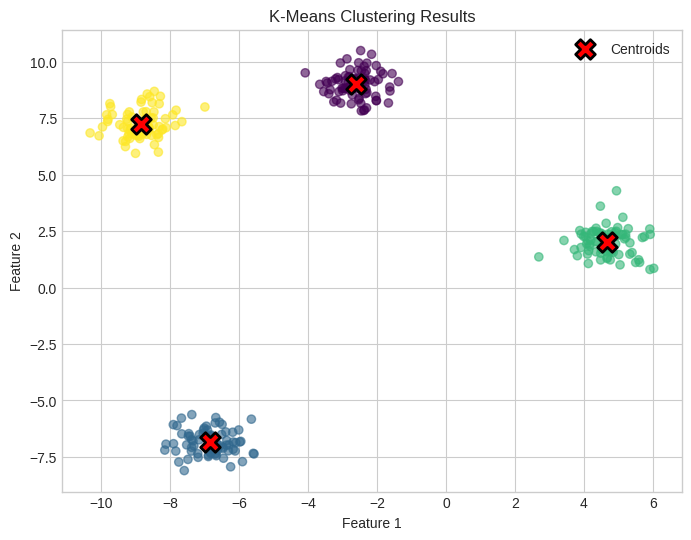

In [6]:
plt.figure(figsize=(8, 6))
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
plt.scatter(
    kmeans_model.cluster_centers_[:, 0],
    kmeans_model.cluster_centers_[:, 1],
    c='red', marker='X', s=200, edgecolors='black', linewidths=2,
    label='Centroids'
)
plt.title('K-Means Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

### Elbow Method for Choosing K

The **elbow method** plots inertia vs K and looks for the "elbow" where adding more clusters provides diminishing returns.

In [7]:
def elbow_method(
    X: np.ndarray,
    k_range: range = range(1, 11)
) -> List[float]:
    """Compute inertia for different values of K.
    
    Args:
        X: Feature matrix.
        k_range: Range of K values to try.
    
    Returns:
        List of inertia values for each K.
    """
    inertias = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
    return inertias

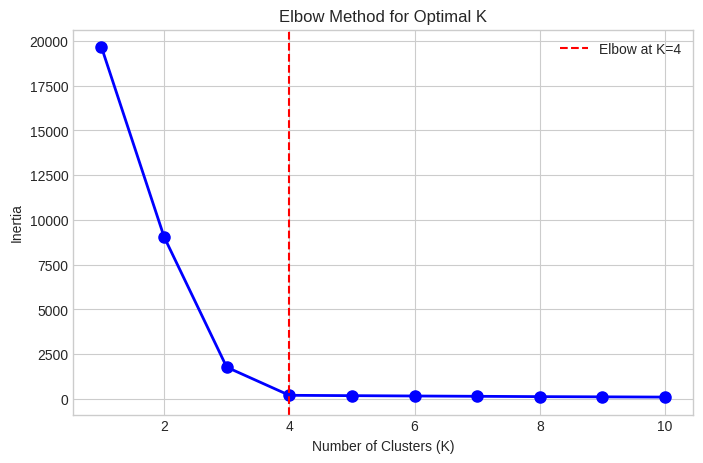

In [8]:
k_range = range(1, 11)
inertias = elbow_method(X_blobs, k_range)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.axvline(x=4, color='red', linestyle='--', label='Elbow at K=4')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.legend()
plt.show()

### Silhouette Analysis

The **silhouette score** measures how similar a point is to its own cluster compared to other clusters. Range: [-1, 1], higher is better.

In [9]:
def silhouette_analysis(
    X: np.ndarray,
    k_range: range = range(2, 11)
) -> List[float]:
    """Compute silhouette scores for different K values.
    
    Args:
        X: Feature matrix.
        k_range: Range of K values to try.
    
    Returns:
        List of silhouette scores for each K.
    """
    scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        scores.append(score)
    return scores

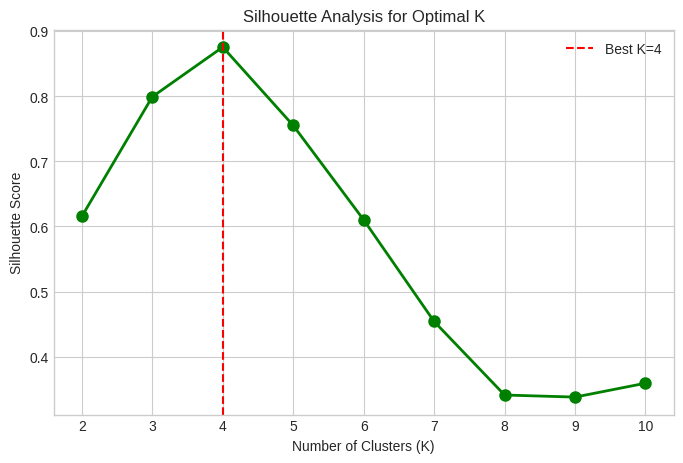

Best K: 4 with score 0.876


In [10]:
k_range = range(2, 11)
silhouette_scores = silhouette_analysis(X_blobs, k_range)

plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
plt.axvline(x=4, color='red', linestyle='--', label='Best K=4')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal K')
plt.legend()
plt.show()

print(f"Best K: {k_range[np.argmax(silhouette_scores)]} with score {max(silhouette_scores):.3f}")

---

## 4. Hierarchical Clustering

**Hierarchical clustering** builds a tree (dendrogram) of clusters, either bottom-up (agglomerative) or top-down (divisive).

**Agglomerative (most common):**
1. Start with each point as its own cluster
2. Merge the two closest clusters
3. Repeat until one cluster remains

**Linkage Methods:**

| Method | Distance Between Clusters |
|--------|---------------------------|
| Single | Minimum distance between points |
| Complete | Maximum distance between points |
| Average | Average distance between all pairs |
| Ward | Minimises variance increase |

In [11]:
def plot_dendrogram(
    X: np.ndarray,
    method: str = 'ward',
    truncate_mode: str = 'level',
    p: int = 5
) -> None:
    """Plot hierarchical clustering dendrogram.
    
    Args:
        X: Feature matrix.
        method: Linkage method.
        truncate_mode: How to truncate dendrogram.
        p: Truncation parameter.
    """
    linked = linkage(X, method=method)
    
    plt.figure(figsize=(12, 6))
    dendrogram(
        linked,
        truncate_mode=truncate_mode,
        p=p,
        leaf_rotation=90,
        leaf_font_size=10
    )
    plt.title(f'Hierarchical Clustering Dendrogram ({method} linkage)')
    plt.xlabel('Sample Index or Cluster Size')
    plt.ylabel('Distance')
    plt.show()

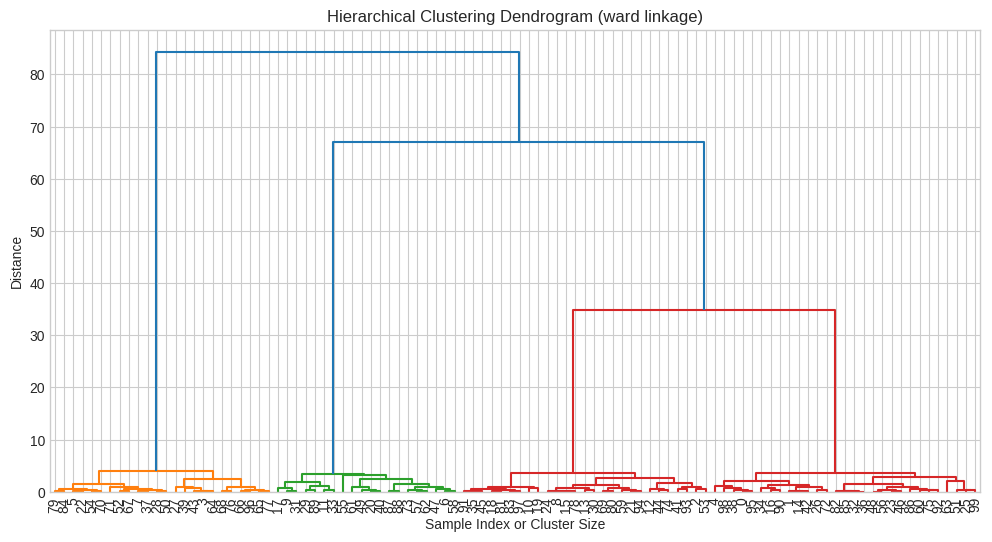

In [12]:
X_sample = X_blobs[:100]
plot_dendrogram(X_sample, method='ward', p=10)

In [13]:
def fit_hierarchical(
    X: np.ndarray,
    n_clusters: int,
    linkage: str = 'ward'
) -> np.ndarray:
    """Fit agglomerative hierarchical clustering.
    
    Args:
        X: Feature matrix.
        n_clusters: Number of clusters.
        linkage: Linkage criterion.
    
    Returns:
        Cluster labels.
    """
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    return model.fit_predict(X)

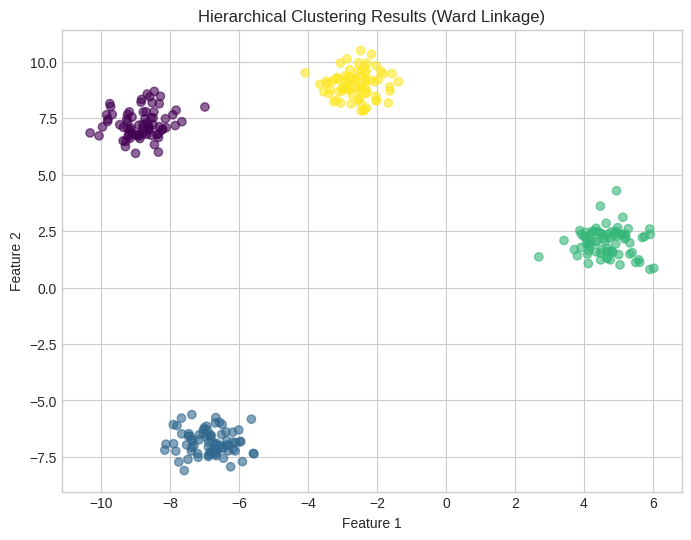

In [14]:
hier_labels = fit_hierarchical(X_blobs, n_clusters=4)

plt.figure(figsize=(8, 6))
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=hier_labels, cmap='viridis', alpha=0.6)
plt.title('Hierarchical Clustering Results (Ward Linkage)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

---

## 5. DBSCAN

**DBSCAN** (Density-Based Spatial Clustering of Applications with Noise) groups points that are closely packed together.

**Key Parameters:**
- **eps**: Maximum distance between two samples to be considered neighbours
- **min_samples**: Minimum points required to form a dense region

**Point Types:**
- **Core point**: Has at least min_samples within eps distance
- **Border point**: Within eps of a core point but not a core itself
- **Noise point**: Neither core nor border (labelled as -1)

**Advantages:**
- No need to specify K
- Can find arbitrarily shaped clusters
- Robust to outliers

In [15]:
def fit_dbscan(
    X: np.ndarray,
    eps: float = 0.5,
    min_samples: int = 5
) -> Tuple[DBSCAN, np.ndarray]:
    """Fit DBSCAN clustering model.
    
    Args:
        X: Feature matrix.
        eps: Maximum neighbour distance.
        min_samples: Minimum points for core point.
    
    Returns:
        Tuple of (fitted DBSCAN model, cluster labels).
    """
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X)
    return dbscan, labels

In [16]:
dbscan_model, dbscan_labels = fit_dbscan(X_moons, eps=0.2, min_samples=5)

n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")

Number of clusters: 2
Number of noise points: 0


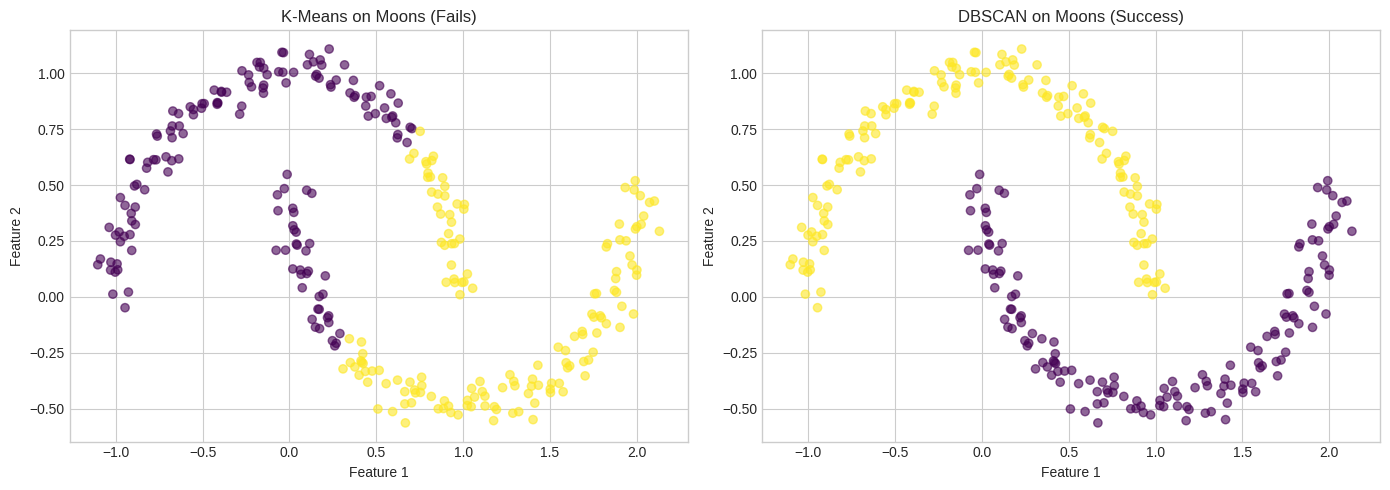

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

kmeans_moons, kmeans_moons_labels = fit_kmeans(X_moons, n_clusters=2)
axes[0].scatter(X_moons[:, 0], X_moons[:, 1], c=kmeans_moons_labels, cmap='viridis', alpha=0.6)
axes[0].set_title('K-Means on Moons (Fails)')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

axes[1].scatter(X_moons[:, 0], X_moons[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.6)
axes[1].set_title('DBSCAN on Moons (Success)')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

---

## 6. Clustering Evaluation Metrics

### Internal Metrics (No Ground Truth)

| Metric | Range | Interpretation |
|--------|-------|----------------|
| Silhouette Score | [-1, 1] | Higher = better separation |
| Calinski-Harabasz | [0, inf) | Higher = denser, well-separated |
| Davies-Bouldin | [0, inf) | Lower = better separation |

### External Metrics (With Ground Truth)

| Metric | Range | Interpretation |
|--------|-------|----------------|
| Adjusted Rand Index | [-1, 1] | 1 = perfect match |
| Normalised Mutual Info | [0, 1] | 1 = perfect match |

In [18]:
def evaluate_clustering(
    X: np.ndarray,
    labels: np.ndarray,
    true_labels: np.ndarray = None
) -> Dict[str, float]:
    """Evaluate clustering quality with multiple metrics.
    
    Args:
        X: Feature matrix.
        labels: Predicted cluster labels.
        true_labels: Ground truth labels (optional).
    
    Returns:
        Dictionary of metric names and values.
    """
    valid_mask = labels != -1
    
    if valid_mask.sum() < 2 or len(np.unique(labels[valid_mask])) < 2:
        return {"Error": "Not enough valid clusters"}
    
    metrics = {
        'Silhouette': silhouette_score(X[valid_mask], labels[valid_mask]),
        'Calinski-Harabasz': calinski_harabasz_score(X[valid_mask], labels[valid_mask]),
        'Davies-Bouldin': davies_bouldin_score(X[valid_mask], labels[valid_mask])
    }
    
    if true_labels is not None:
        metrics['Adjusted Rand Index'] = adjusted_rand_score(true_labels, labels)
        metrics['Normalised Mutual Info'] = normalized_mutual_info_score(true_labels, labels)
    
    return metrics

In [19]:
print("K-Means Evaluation (Blobs):")
kmeans_metrics = evaluate_clustering(X_blobs, kmeans_labels, y_blobs)
for metric, value in kmeans_metrics.items():
    print(f"  {metric}: {value:.4f}")

print("\nDBSCAN Evaluation (Moons):")
dbscan_metrics = evaluate_clustering(X_moons, dbscan_labels, y_moons)
for metric, value in dbscan_metrics.items():
    print(f"  {metric}: {value:.4f}")

K-Means Evaluation (Blobs):
  Silhouette: 0.8756
  Calinski-Harabasz: 9411.5067
  Davies-Bouldin: 0.1737
  Adjusted Rand Index: 1.0000
  Normalised Mutual Info: 1.0000

DBSCAN Evaluation (Moons):
  Silhouette: 0.3308
  Calinski-Harabasz: 198.3790
  Davies-Bouldin: 1.1521
  Adjusted Rand Index: 1.0000
  Normalised Mutual Info: 1.0000


---

## 7. Dimensionality Reduction Overview

**Dimensionality reduction** transforms high-dimensional data to lower dimensions while preserving important structure.

**Use Cases:**
- Visualisation (reduce to 2D/3D)
- Noise reduction
- Feature extraction
- Computational efficiency

| Method | Type | Preserves | Best For |
|--------|------|-----------|----------|
| PCA | Linear | Global variance | Feature extraction, preprocessing |
| t-SNE | Non-linear | Local structure | Visualisation |
| UMAP | Non-linear | Local + global | Visualisation, clustering |

---

## 8. Principal Component Analysis (PCA)

**PCA** finds orthogonal directions (principal components) that capture maximum variance in the data.

**Algorithm:**
1. Centre the data (subtract mean)
2. Compute covariance matrix
3. Find eigenvectors and eigenvalues
4. Sort by eigenvalue (variance explained)
5. Project data onto top K eigenvectors

**Key Concepts:**
- **Explained variance ratio**: How much variance each component captures
- **Cumulative explained variance**: Total variance captured by first K components
- **Loadings**: How much each original feature contributes to each component

In [20]:
def fit_pca(
    X: np.ndarray,
    n_components: int = 2
) -> Tuple[PCA, np.ndarray]:
    """Fit PCA and transform data.
    
    Args:
        X: Feature matrix.
        n_components: Number of components to keep.
    
    Returns:
        Tuple of (fitted PCA model, transformed data).
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    return pca, X_pca

In [21]:
pca_model, X_iris_pca = fit_pca(X_iris, n_components=2)

print(f"Original shape: {X_iris.shape}")
print(f"Reduced shape: {X_iris_pca.shape}")
print(f"\nExplained variance ratio: {pca_model.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca_model.explained_variance_ratio_):.4f}")

Original shape: (150, 4)
Reduced shape: (150, 2)

Explained variance ratio: [0.72962445 0.22850762]
Total variance explained: 0.9581


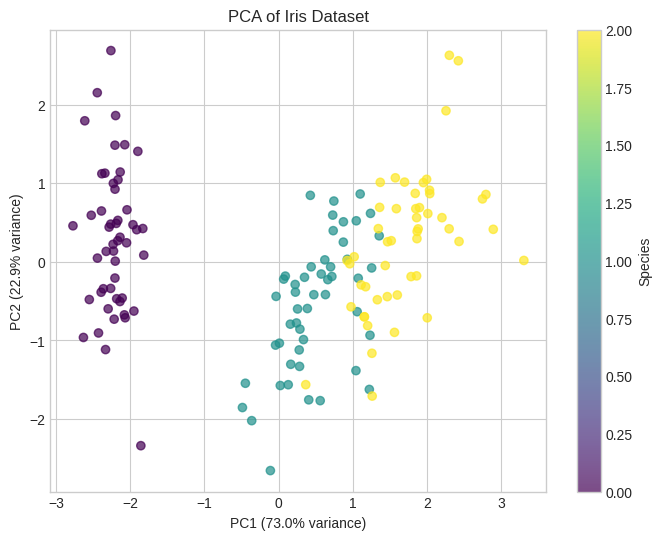

In [22]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_iris_pca[:, 0], X_iris_pca[:, 1], c=y_iris, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Species')
plt.xlabel(f'PC1 ({pca_model.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca_model.explained_variance_ratio_[1]:.1%} variance)')
plt.title('PCA of Iris Dataset')
plt.show()

### Choosing Number of Components

In [23]:
def plot_explained_variance(X: np.ndarray) -> None:
    """Plot cumulative explained variance to choose n_components.
    
    Args:
        X: Feature matrix.
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    pca = PCA()
    pca.fit(X_scaled)
    
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].bar(range(1, len(pca.explained_variance_ratio_) + 1), 
                pca.explained_variance_ratio_, alpha=0.7)
    axes[0].set_xlabel('Principal Component')
    axes[0].set_ylabel('Explained Variance Ratio')
    axes[0].set_title('Scree Plot')
    
    axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-')
    axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
    axes[1].set_xlabel('Number of Components')
    axes[1].set_ylabel('Cumulative Explained Variance')
    axes[1].set_title('Cumulative Explained Variance')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

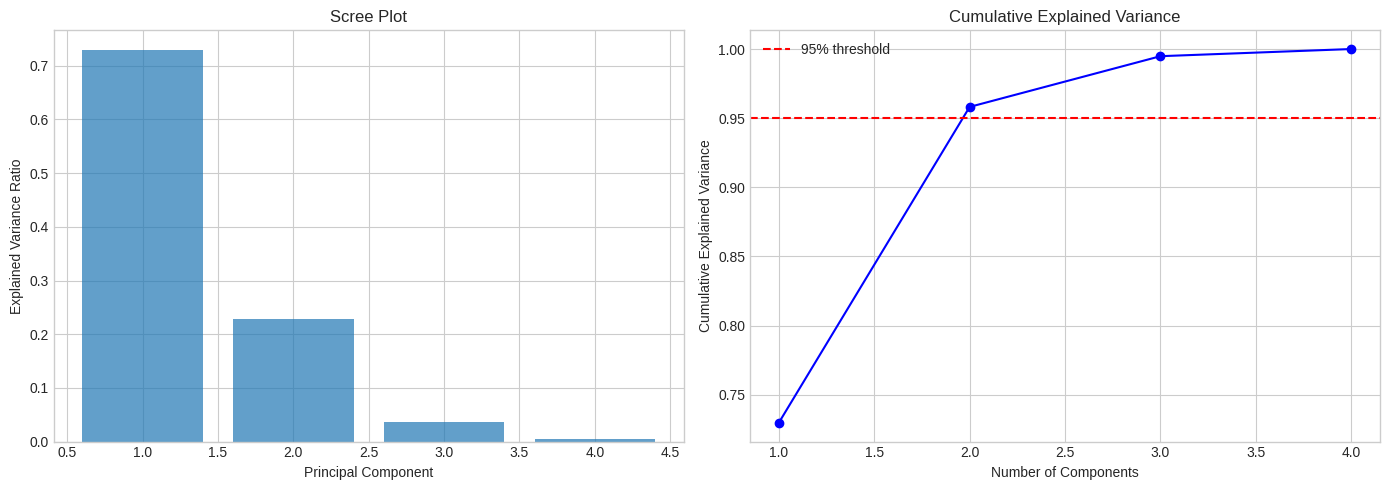

In [24]:
plot_explained_variance(X_iris)

---

## 9. t-SNE

**t-SNE** (t-distributed Stochastic Neighbour Embedding) is a non-linear technique that preserves local structure, making it excellent for visualisation.

**How it works:**
1. Compute pairwise similarities in high-dimensional space (Gaussian)
2. Compute pairwise similarities in low-dimensional space (t-distribution)
3. Minimise KL divergence between the two distributions

**Key Parameters:**
- **perplexity**: Balance between local and global structure (typically 5-50)
- **n_iter**: Number of iterations
- **learning_rate**: Step size for optimisation

**Limitations:**
- Computationally expensive
- Non-deterministic (different runs give different results)
- Cannot transform new data (no `transform` method)
- Distances in output are not meaningful

In [25]:
def fit_tsne(
    X: np.ndarray,
    n_components: int = 2,
    perplexity: float = 30.0,
    random_state: int = 42
) -> np.ndarray:
    """Fit t-SNE and transform data.
    
    Args:
        X: Feature matrix.
        n_components: Number of output dimensions.
        perplexity: Perplexity parameter.
        random_state: Random seed.
    
    Returns:
        Transformed data.
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    tsne = TSNE(
        n_components=n_components,
        perplexity=perplexity,
        random_state=random_state,
        max_iter=1000
    )
    
    return tsne.fit_transform(X_scaled)

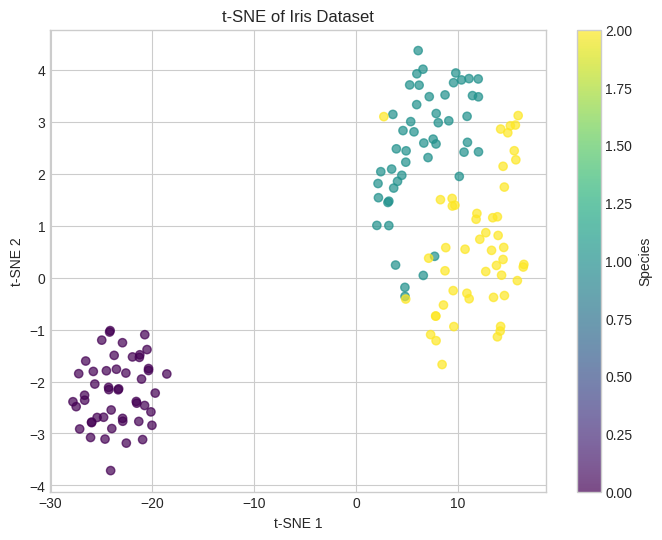

In [26]:
X_iris_tsne = fit_tsne(X_iris, perplexity=30)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_iris_tsne[:, 0], X_iris_tsne[:, 1], c=y_iris, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Species')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE of Iris Dataset')
plt.show()

### Effect of Perplexity

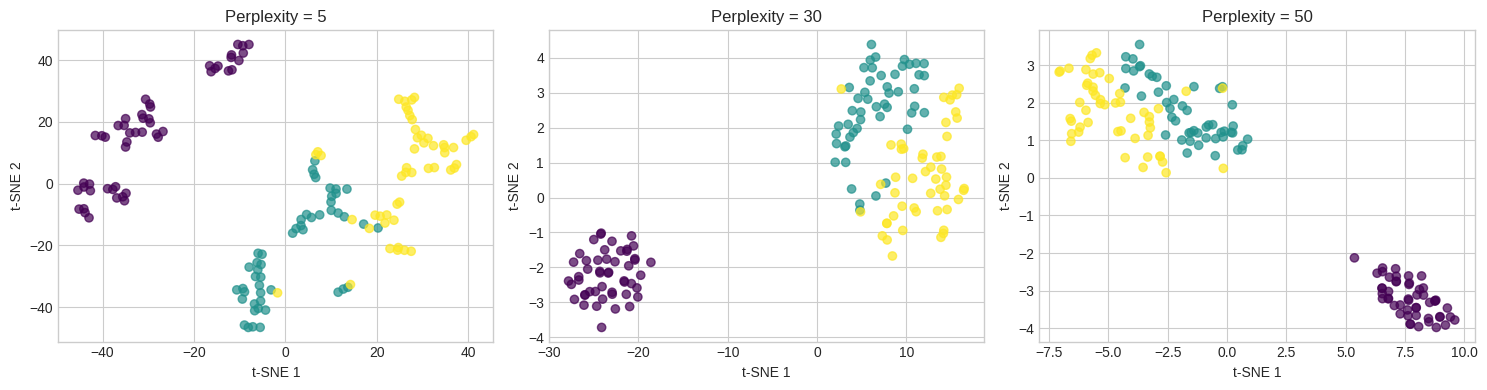

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
perplexities = [5, 30, 50]

for ax, perp in zip(axes, perplexities):
    X_tsne = fit_tsne(X_iris, perplexity=perp)
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_iris, cmap='viridis', alpha=0.7)
    ax.set_title(f'Perplexity = {perp}')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')

plt.tight_layout()
plt.show()

---

## 10. UMAP

**UMAP** (Uniform Manifold Approximation and Projection) is a newer technique that often outperforms t-SNE.

**Advantages over t-SNE:**
- Faster (especially for large datasets)
- Preserves more global structure
- Can transform new data
- More deterministic

**Key Parameters:**
- **n_neighbors**: Size of local neighbourhood (like perplexity)
- **min_dist**: Minimum distance between points in output
- **metric**: Distance metric to use

**Note**: UMAP requires the `umap-learn` package. We'll demonstrate the concept with sklearn's implementation notes.

In [28]:
try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False
    print("UMAP not installed. Install with: pip install umap-learn")
    print("Skipping UMAP demonstration.")

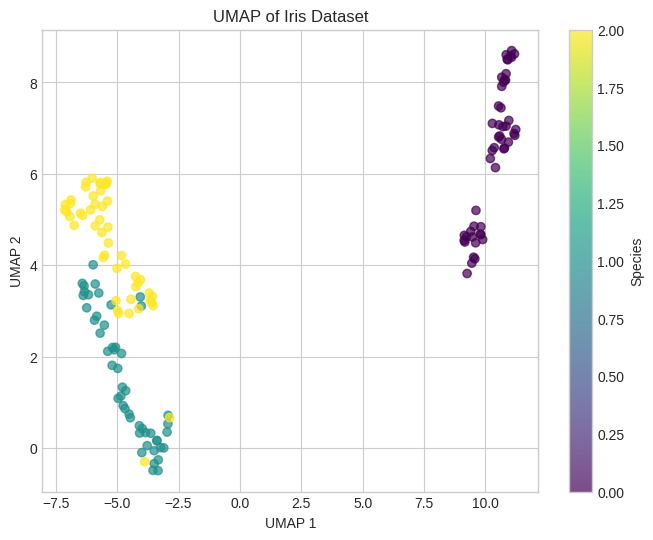

In [29]:
if UMAP_AVAILABLE:
    def fit_umap(
        X: np.ndarray,
        n_components: int = 2,
        n_neighbors: int = 15,
        min_dist: float = 0.1,
        random_state: int = 42
    ) -> np.ndarray:
        """Fit UMAP and transform data.
        
        Args:
            X: Feature matrix.
            n_components: Number of output dimensions.
            n_neighbors: Size of local neighbourhood.
            min_dist: Minimum distance in output.
            random_state: Random seed.
        
        Returns:
            Transformed data.
        """
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        reducer = umap.UMAP(
            n_components=n_components,
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            random_state=random_state
        )
        
        return reducer.fit_transform(X_scaled)
    
    X_iris_umap = fit_umap(X_iris)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_iris_umap[:, 0], X_iris_umap[:, 1], c=y_iris, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Species')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title('UMAP of Iris Dataset')
    plt.show()

### Comparison of Dimensionality Reduction Methods

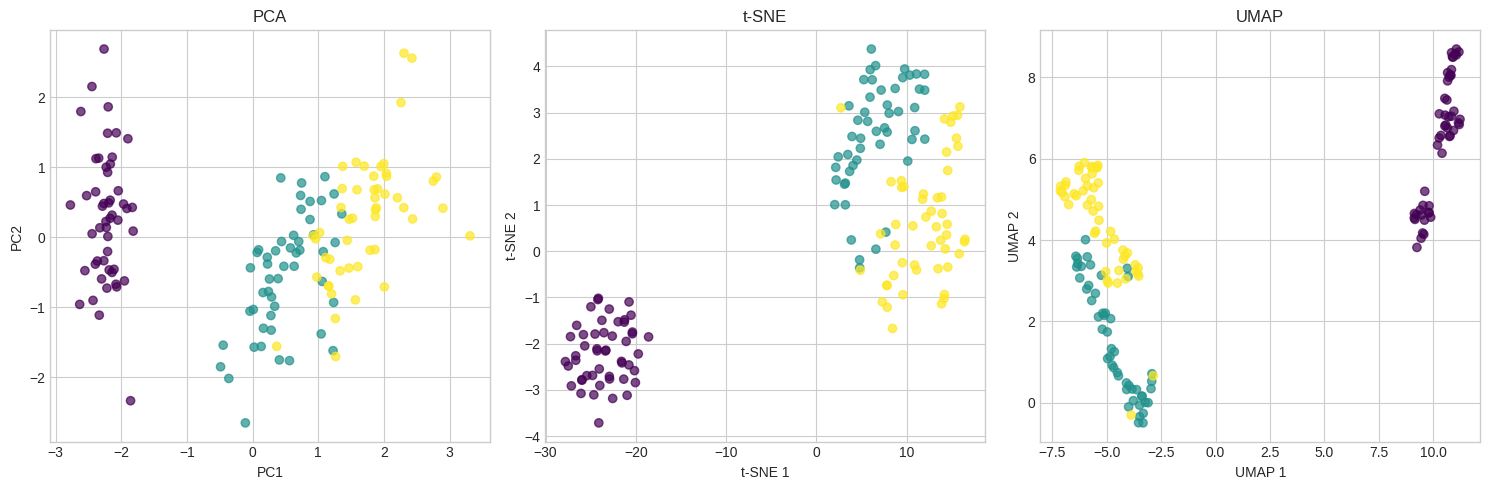

In [30]:
fig, axes = plt.subplots(1, 3 if UMAP_AVAILABLE else 2, figsize=(15 if UMAP_AVAILABLE else 12, 5))

axes[0].scatter(X_iris_pca[:, 0], X_iris_pca[:, 1], c=y_iris, cmap='viridis', alpha=0.7)
axes[0].set_title('PCA')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

axes[1].scatter(X_iris_tsne[:, 0], X_iris_tsne[:, 1], c=y_iris, cmap='viridis', alpha=0.7)
axes[1].set_title('t-SNE')
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')

if UMAP_AVAILABLE:
    axes[2].scatter(X_iris_umap[:, 0], X_iris_umap[:, 1], c=y_iris, cmap='viridis', alpha=0.7)
    axes[2].set_title('UMAP')
    axes[2].set_xlabel('UMAP 1')
    axes[2].set_ylabel('UMAP 2')

plt.tight_layout()
plt.show()

---

## 11. Anomaly Detection

**Anomaly detection** identifies data points that deviate significantly from the norm.

**Types of Anomalies:**
- **Point anomalies**: Individual outliers
- **Contextual anomalies**: Anomalous in specific context
- **Collective anomalies**: Group of points that are anomalous together

**Common Methods:**

| Method | Approach | Best For |
|--------|----------|----------|
| Isolation Forest | Tree-based isolation | High-dimensional data |
| Local Outlier Factor | Density-based | Local anomalies |
| One-Class SVM | Boundary-based | Well-defined normal class |

### Isolation Forest

**Isolation Forest** isolates anomalies by randomly selecting features and split values. Anomalies are easier to isolate (shorter path length).

In [31]:
np.random.seed(42)
X_normal = np.random.randn(200, 2)
X_anomalies = np.random.uniform(low=-4, high=4, size=(20, 2))
X_combined = np.vstack([X_normal, X_anomalies])
y_true = np.array([1] * 200 + [-1] * 20)

print(f"Normal points: {len(X_normal)}")
print(f"Anomaly points: {len(X_anomalies)}")

Normal points: 200
Anomaly points: 20


In [32]:
def fit_isolation_forest(
    X: np.ndarray,
    contamination: float = 0.1,
    random_state: int = 42
) -> Tuple[IsolationForest, np.ndarray]:
    """Fit Isolation Forest for anomaly detection.
    
    Args:
        X: Feature matrix.
        contamination: Expected proportion of anomalies.
        random_state: Random seed.
    
    Returns:
        Tuple of (fitted model, predictions: 1=normal, -1=anomaly).
    """
    iso_forest = IsolationForest(
        contamination=contamination,
        random_state=random_state,
        n_estimators=100
    )
    predictions = iso_forest.fit_predict(X)
    return iso_forest, predictions

In [33]:
iso_model, iso_predictions = fit_isolation_forest(X_combined, contamination=0.1)

n_detected = (iso_predictions == -1).sum()
print(f"Detected anomalies: {n_detected}")
print(f"True anomalies: 20")

Detected anomalies: 22
True anomalies: 20


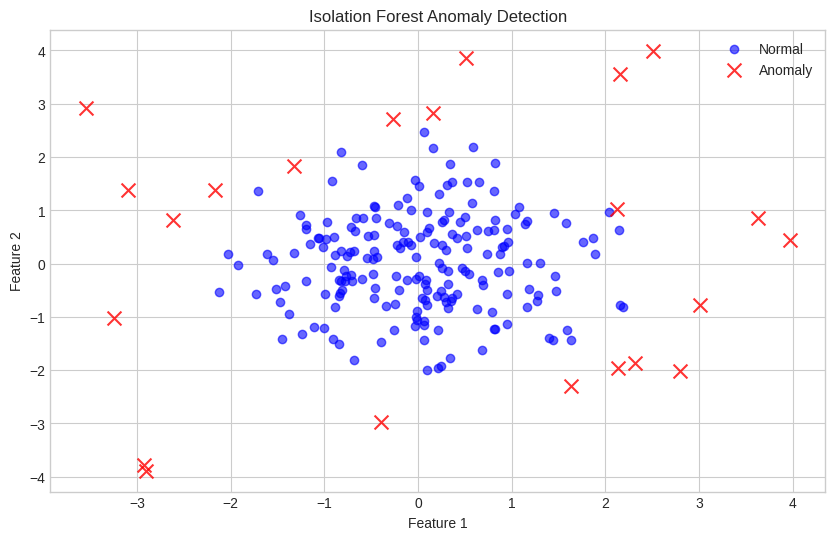

In [34]:
plt.figure(figsize=(10, 6))

normal_mask = iso_predictions == 1
anomaly_mask = iso_predictions == -1

plt.scatter(X_combined[normal_mask, 0], X_combined[normal_mask, 1], 
            c='blue', label='Normal', alpha=0.6)
plt.scatter(X_combined[anomaly_mask, 0], X_combined[anomaly_mask, 1], 
            c='red', label='Anomaly', alpha=0.8, marker='x', s=100)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Isolation Forest Anomaly Detection')
plt.legend()
plt.show()

### Local Outlier Factor (LOF)

**LOF** compares the local density of a point to its neighbours. Points with substantially lower density are anomalies.

In [35]:
def fit_lof(
    X: np.ndarray,
    n_neighbors: int = 20,
    contamination: float = 0.1
) -> Tuple[LocalOutlierFactor, np.ndarray]:
    """Fit Local Outlier Factor for anomaly detection.
    
    Args:
        X: Feature matrix.
        n_neighbors: Number of neighbours for density estimation.
        contamination: Expected proportion of anomalies.
    
    Returns:
        Tuple of (fitted model, predictions: 1=normal, -1=anomaly).
    """
    lof = LocalOutlierFactor(
        n_neighbors=n_neighbors,
        contamination=contamination,
        novelty=False
    )
    predictions = lof.fit_predict(X)
    return lof, predictions

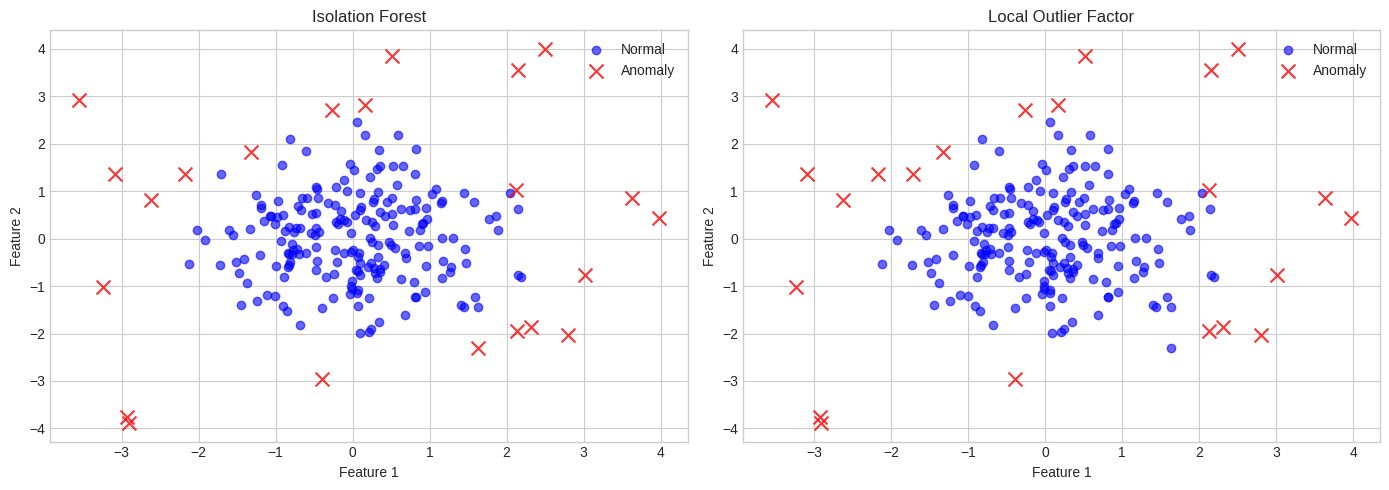

In [36]:
lof_model, lof_predictions = fit_lof(X_combined, contamination=0.1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (predictions, title) in zip(axes, [(iso_predictions, 'Isolation Forest'), 
                                            (lof_predictions, 'Local Outlier Factor')]):
    normal_mask = predictions == 1
    anomaly_mask = predictions == -1
    
    ax.scatter(X_combined[normal_mask, 0], X_combined[normal_mask, 1], 
               c='blue', label='Normal', alpha=0.6)
    ax.scatter(X_combined[anomaly_mask, 0], X_combined[anomaly_mask, 1], 
               c='red', label='Anomaly', alpha=0.8, marker='x', s=100)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(title)
    ax.legend()

plt.tight_layout()
plt.show()

### Statistical Anomaly Detection

In [37]:
def detect_anomalies_zscore(
    X: np.ndarray,
    threshold: float = 3.0
) -> np.ndarray:
    """Detect anomalies using Z-score method.
    
    Args:
        X: Feature matrix.
        threshold: Z-score threshold for anomaly.
    
    Returns:
        Boolean array (True = anomaly).
    """
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    z_scores = np.abs((X - mean) / std)
    return np.any(z_scores > threshold, axis=1)


def detect_anomalies_iqr(
    X: np.ndarray,
    multiplier: float = 1.5
) -> np.ndarray:
    """Detect anomalies using IQR method.
    
    Args:
        X: Feature matrix.
        multiplier: IQR multiplier for bounds.
    
    Returns:
        Boolean array (True = anomaly).
    """
    Q1 = np.percentile(X, 25, axis=0)
    Q3 = np.percentile(X, 75, axis=0)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    return np.any((X < lower_bound) | (X > upper_bound), axis=1)

In [38]:
zscore_anomalies = detect_anomalies_zscore(X_combined, threshold=2.5)
iqr_anomalies = detect_anomalies_iqr(X_combined, multiplier=1.5)

print(f"Z-score detected anomalies: {zscore_anomalies.sum()}")
print(f"IQR detected anomalies: {iqr_anomalies.sum()}")

Z-score detected anomalies: 12
IQR detected anomalies: 14


## 12. Practice Questions

Test your understanding with these interview-style questions. Try to solve each question in the empty code cell before revealing the answer.

### Question 1: K-Means from Scratch

Implement a simplified K-Means algorithm from scratch.

In [ ]:
# Write your solution here

<details>
<summary>Click to reveal answer</summary>

```python
import numpy as np
from typing import Tuple

def kmeans_scratch(
    X: np.ndarray,
    k: int,
    max_iters: int = 100,
    random_state: int = 42
) -> Tuple[np.ndarray, np.ndarray]:
    """K-Means clustering from scratch.
    
    Args:
        X: Feature matrix.
        k: Number of clusters.
        max_iters: Maximum iterations.
        random_state: Random seed.
    
    Returns:
        Tuple of (centroids, labels).
    """
    np.random.seed(random_state)
    n_samples = X.shape[0]
    
    # Randomly initialise centroids
    indices = np.random.choice(n_samples, k, replace=False)
    centroids = X[indices].copy()
    
    for _ in range(max_iters):
        # Assign points to nearest centroid
        distances = np.sqrt(((X[:, np.newaxis] - centroids) ** 2).sum(axis=2))
        labels = np.argmin(distances, axis=1)
        
        # Update centroids
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
        
        # Check convergence
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids
    
    return centroids, labels


# Test
X_test, _ = make_blobs(n_samples=100, centers=3, random_state=42)
centroids, labels = kmeans_scratch(X_test, k=3)
print(f"Centroids shape: {centroids.shape}")
print(f"Unique labels: {np.unique(labels)}")
```

</details>


---

### Question 2: Optimal K Selection

Write a function that uses both elbow and silhouette methods to suggest optimal K.

In [ ]:
# Write your solution here

<details>
<summary>Click to reveal answer</summary>

```python
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

def find_optimal_k(
    X: np.ndarray,
    k_range: range = range(2, 11)
) -> dict:
    """Find optimal K using multiple methods.
    
    Args:
        X: Feature matrix.
        k_range: Range of K values to try.
    
    Returns:
        Dictionary with analysis results.
    """
    inertias = []
    silhouettes = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X, labels))
    
    # Find elbow using second derivative
    diffs = np.diff(inertias)
    elbow_k = k_range[np.argmax(np.diff(diffs)) + 2]
    
    # Best silhouette
    best_silhouette_k = k_range[np.argmax(silhouettes)]
    
    return {
        'elbow_k': elbow_k,
        'silhouette_k': best_silhouette_k,
        'inertias': inertias,
        'silhouettes': silhouettes
    }


# Test
X_test, _ = make_blobs(n_samples=300, centers=4, random_state=42)
results = find_optimal_k(X_test)
print(f"Elbow suggests K={results['elbow_k']}")
print(f"Silhouette suggests K={results['silhouette_k']}")
```

</details>


---

### Question 3: PCA Explained Variance

Find the number of components needed to explain at least 95% of variance.

In [ ]:
# Write your solution here

<details>
<summary>Click to reveal answer</summary>

```python
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

def find_n_components(
    X: np.ndarray,
    variance_threshold: float = 0.95
) -> int:
    """Find number of PCA components for given variance threshold.
    
    Args:
        X: Feature matrix.
        variance_threshold: Minimum cumulative variance to explain.
    
    Returns:
        Number of components needed.
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    pca = PCA()
    pca.fit(X_scaled)
    
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
    
    return n_components


# Test
from sklearn.datasets import load_iris
iris = load_iris()
n = find_n_components(iris.data, 0.95)
print(f"Components needed for 95% variance: {n}")
```

</details>


---

### Question 4: DBSCAN Parameter Tuning

Implement a function to find good eps value using k-distance graph.

In [ ]:
# Write your solution here

<details>
<summary>Click to reveal answer</summary>

```python
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

def plot_k_distance(
    X: np.ndarray,
    k: int = 5
) -> np.ndarray:
    """Plot k-distance graph to find optimal eps for DBSCAN.
    
    Args:
        X: Feature matrix.
        k: Number of nearest neighbours (min_samples - 1).
    
    Returns:
        Sorted k-distances.
    """
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(X)
    distances, _ = nn.kneighbors(X)
    
    k_distances = np.sort(distances[:, -1])[::-1]
    
    plt.figure(figsize=(8, 5))
    plt.plot(k_distances)
    plt.xlabel('Points (sorted by distance)')
    plt.ylabel(f'{k}-th Nearest Neighbour Distance')
    plt.title('K-Distance Graph for DBSCAN eps Selection')
    plt.show()
    
    return k_distances


# Test
X_test, _ = make_moons(n_samples=200, noise=0.05, random_state=42)
distances = plot_k_distance(X_test, k=5)
print(f"Suggested eps (elbow): ~{distances[int(len(distances)*0.1)]:.3f}")
```

</details>


---

### Question 5: Clustering Comparison

Compare K-Means, Hierarchical, and DBSCAN on a dataset and return the best method.

In [ ]:
# Write your solution here

<details>
<summary>Click to reveal answer</summary>

```python
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from typing import Dict

def compare_clustering_methods(
    X: np.ndarray,
    n_clusters: int = 3
) -> Dict[str, float]:
    """Compare clustering methods using silhouette score.
    
    Args:
        X: Feature matrix.
        n_clusters: Number of clusters (for K-Means and Hierarchical).
    
    Returns:
        Dictionary of method names and silhouette scores.
    """
    results = {}
    
    # K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X)
    results['K-Means'] = silhouette_score(X, kmeans_labels)
    
    # Hierarchical
    hier = AgglomerativeClustering(n_clusters=n_clusters)
    hier_labels = hier.fit_predict(X)
    results['Hierarchical'] = silhouette_score(X, hier_labels)
    
    # DBSCAN
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X)
    if len(set(dbscan_labels) - {-1}) >= 2:
        valid_mask = dbscan_labels != -1
        results['DBSCAN'] = silhouette_score(X[valid_mask], dbscan_labels[valid_mask])
    else:
        results['DBSCAN'] = -1
    
    return results


# Test
X_test, _ = make_blobs(n_samples=200, centers=3, random_state=42)
scores = compare_clustering_methods(X_test, n_clusters=3)
for method, score in scores.items():
    print(f"{method}: {score:.4f}")
print(f"Best method: {max(scores, key=scores.get)}")
```

</details>


---

### Question 6: Anomaly Detection Pipeline

Create a function that combines multiple anomaly detection methods and returns consensus anomalies.

In [ ]:
# Write your solution here

<details>
<summary>Click to reveal answer</summary>

```python
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import numpy as np

def ensemble_anomaly_detection(
    X: np.ndarray,
    contamination: float = 0.1,
    consensus_threshold: int = 2
) -> np.ndarray:
    """Detect anomalies using ensemble of methods.
    
    Args:
        X: Feature matrix.
        contamination: Expected anomaly proportion.
        consensus_threshold: Minimum methods that must agree.
    
    Returns:
        Boolean array (True = anomaly).
    """
    # Isolation Forest
    iso = IsolationForest(contamination=contamination, random_state=42)
    iso_pred = iso.fit_predict(X) == -1
    
    # LOF
    lof = LocalOutlierFactor(contamination=contamination)
    lof_pred = lof.fit_predict(X) == -1
    
    # Z-score
    z_scores = np.abs((X - X.mean(axis=0)) / X.std(axis=0))
    zscore_pred = np.any(z_scores > 3, axis=1)
    
    # Consensus
    votes = iso_pred.astype(int) + lof_pred.astype(int) + zscore_pred.astype(int)
    
    return votes >= consensus_threshold


# Test
np.random.seed(42)
X_normal = np.random.randn(100, 2)
X_outliers = np.random.uniform(-5, 5, (10, 2))
X_test = np.vstack([X_normal, X_outliers])

anomalies = ensemble_anomaly_detection(X_test)
print(f"Detected anomalies: {anomalies.sum()}")
```

</details>


---

### Question 7: PCA Feature Importance

Determine which original features contribute most to the first principal component.

In [ ]:
# Write your solution here

<details>
<summary>Click to reveal answer</summary>

```python
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from typing import List, Tuple

def pca_feature_importance(
    X: np.ndarray,
    feature_names: List[str],
    n_components: int = 1
) -> List[Tuple[str, float]]:
    """Get feature importance from PCA loadings.
    
    Args:
        X: Feature matrix.
        feature_names: Names of features.
        n_components: Number of components to analyse.
    
    Returns:
        List of (feature_name, importance) tuples sorted by importance.
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    pca = PCA(n_components=n_components)
    pca.fit(X_scaled)
    
    # Loadings for first component (absolute values)
    loadings = np.abs(pca.components_[0])
    
    importance = list(zip(feature_names, loadings))
    importance.sort(key=lambda x: x[1], reverse=True)
    
    return importance


# Test
from sklearn.datasets import load_iris
iris = load_iris()
importance = pca_feature_importance(iris.data, iris.feature_names)
print("Feature importance (PC1):")
for name, score in importance:
    print(f"  {name}: {score:.4f}")
```

</details>


---

### Question 8: Silhouette Score from Scratch

Implement silhouette score calculation without using sklearn.

In [ ]:
# Write your solution here

<details>
<summary>Click to reveal answer</summary>

```python
import numpy as np
from scipy.spatial.distance import cdist

def silhouette_score_scratch(
    X: np.ndarray,
    labels: np.ndarray
) -> float:
    """Compute silhouette score from scratch.
    
    Args:
        X: Feature matrix.
        labels: Cluster labels.
    
    Returns:
        Mean silhouette score.
    """
    n_samples = len(X)
    unique_labels = np.unique(labels)
    
    distances = cdist(X, X, metric='euclidean')
    silhouettes = []
    
    for i in range(n_samples):
        # a(i): mean distance to same cluster
        same_cluster = labels == labels[i]
        same_cluster[i] = False
        if same_cluster.sum() > 0:
            a_i = distances[i, same_cluster].mean()
        else:
            a_i = 0
        
        # b(i): min mean distance to other clusters
        b_i = float('inf')
        for label in unique_labels:
            if label != labels[i]:
                other_cluster = labels == label
                mean_dist = distances[i, other_cluster].mean()
                b_i = min(b_i, mean_dist)
        
        # Silhouette for point i
        s_i = (b_i - a_i) / max(a_i, b_i) if max(a_i, b_i) > 0 else 0
        silhouettes.append(s_i)
    
    return np.mean(silhouettes)


# Test and compare
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X, _ = make_blobs(n_samples=100, centers=3, random_state=42)
labels = KMeans(n_clusters=3, random_state=42, n_init=10).fit_predict(X)

scratch_score = silhouette_score_scratch(X, labels)
sklearn_score = silhouette_score(X, labels)

print(f"From scratch: {scratch_score:.4f}")
print(f"Sklearn: {sklearn_score:.4f}")
```

</details>


---

### Question 9: Cluster Assignment for New Data

Given trained K-Means centroids, assign new data points to clusters.

In [ ]:
# Write your solution here

<details>
<summary>Click to reveal answer</summary>

```python
import numpy as np

def assign_to_clusters(
    X_new: np.ndarray,
    centroids: np.ndarray
) -> np.ndarray:
    """Assign new points to existing clusters.
    
    Args:
        X_new: New data points.
        centroids: Cluster centroids from training.
    
    Returns:
        Cluster assignments for new points.
    """
    distances = np.sqrt(((X_new[:, np.newaxis] - centroids) ** 2).sum(axis=2))
    return np.argmin(distances, axis=1)


# Test
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

X_train, _ = make_blobs(n_samples=100, centers=3, random_state=42)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(X_train)

X_new = np.array([[0, 0], [5, 5], [-5, -5]])
labels_scratch = assign_to_clusters(X_new, kmeans.cluster_centers_)
labels_sklearn = kmeans.predict(X_new)

print(f"From scratch: {labels_scratch}")
print(f"Sklearn: {labels_sklearn}")
```

</details>


---

### Question 10: Hierarchical Clustering Cut

Given a dendrogram, determine the optimal number of clusters by finding the largest gap.

In [ ]:
# Write your solution here

<details>
<summary>Click to reveal answer</summary>

```python
from scipy.cluster.hierarchy import linkage, fcluster
import numpy as np

def find_optimal_clusters_hierarchical(
    X: np.ndarray,
    method: str = 'ward'
) -> int:
    """Find optimal clusters by largest gap in dendrogram.
    
    Args:
        X: Feature matrix.
        method: Linkage method.
    
    Returns:
        Optimal number of clusters.
    """
    Z = linkage(X, method=method)
    
    # Distances at each merge (column 2)
    distances = Z[:, 2]
    
    # Find largest gap
    gaps = np.diff(distances)
    largest_gap_idx = np.argmax(gaps)
    
    # Number of clusters = n - largest_gap_idx - 1
    n_clusters = len(X) - largest_gap_idx - 1
    
    # Cap at reasonable range
    n_clusters = min(max(n_clusters, 2), 10)
    
    return n_clusters


# Test
from sklearn.datasets import make_blobs

X, _ = make_blobs(n_samples=100, centers=4, random_state=42)
n_clusters = find_optimal_clusters_hierarchical(X)
print(f"Optimal clusters: {n_clusters}")
```

</details>


---

### Question 11: Dimensionality Reduction for Clustering

Create a pipeline that applies PCA before K-Means and evaluates the result.

In [ ]:
# Write your solution here

<details>
<summary>Click to reveal answer</summary>

```python
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
import numpy as np

def pca_kmeans_pipeline(
    X: np.ndarray,
    n_clusters: int,
    n_components: int = None,
    variance_threshold: float = 0.95
) -> dict:
    """Apply PCA then K-Means clustering.
    
    Args:
        X: Feature matrix.
        n_clusters: Number of clusters.
        n_components: PCA components (auto if None).
        variance_threshold: Variance threshold if n_components is None.
    
    Returns:
        Dictionary with labels, scores, and component info.
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    if n_components is None:
        pca_full = PCA()
        pca_full.fit(X_scaled)
        cumvar = np.cumsum(pca_full.explained_variance_ratio_)
        n_components = np.argmax(cumvar >= variance_threshold) + 1
    
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)
    
    return {
        'labels': labels,
        'n_components': n_components,
        'variance_explained': sum(pca.explained_variance_ratio_),
        'silhouette_score': silhouette_score(X_pca, labels)
    }


# Test
from sklearn.datasets import load_wine
wine = load_wine()
results = pca_kmeans_pipeline(wine.data, n_clusters=3)
print(f"Components used: {results['n_components']}")
print(f"Variance explained: {results['variance_explained']:.2%}")
print(f"Silhouette score: {results['silhouette_score']:.4f}")
```

</details>


---

### Question 12: Cluster Profiling

Create a function that profiles clusters by computing statistics for each feature.

In [ ]:
# Write your solution here

<details>
<summary>Click to reveal answer</summary>

```python
import pandas as pd
import numpy as np
from typing import List

def profile_clusters(
    X: np.ndarray,
    labels: np.ndarray,
    feature_names: List[str]
) -> pd.DataFrame:
    """Profile clusters by computing feature statistics.
    
    Args:
        X: Feature matrix.
        labels: Cluster labels.
        feature_names: Names of features.
    
    Returns:
        DataFrame with cluster profiles.
    """
    df = pd.DataFrame(X, columns=feature_names)
    df['cluster'] = labels
    
    # Compute mean and std for each cluster
    profile = df.groupby('cluster').agg(['mean', 'std'])
    
    # Add cluster sizes
    sizes = df['cluster'].value_counts().sort_index()
    
    # Flatten column names
    profile.columns = ['_'.join(col) for col in profile.columns]
    profile['size'] = sizes.values
    
    return profile


# Test
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

iris = load_iris()
labels = KMeans(n_clusters=3, random_state=42, n_init=10).fit_predict(iris.data)
profile = profile_clusters(iris.data, labels, iris.feature_names)
print(profile[['sepal length (cm)_mean', 'petal length (cm)_mean', 'size']])
```

</details>


---

## 13. Summary

This notebook covered essential unsupervised learning concepts:

1. **Clustering Overview**: Understanding when to use different clustering algorithms
2. **K-Means**: Partition-based clustering with elbow and silhouette methods
3. **Hierarchical Clustering**: Dendrogram-based clustering with different linkages
4. **DBSCAN**: Density-based clustering that handles noise and arbitrary shapes
5. **Clustering Metrics**: Internal (silhouette, Calinski-Harabasz) and external (ARI, NMI)
6. **PCA**: Linear dimensionality reduction preserving variance
7. **t-SNE**: Non-linear visualisation preserving local structure
8. **UMAP**: Fast non-linear reduction preserving global and local structure
9. **Anomaly Detection**: Isolation Forest, LOF, and statistical methods

---

### Key Interview Tips

- **Know the trade-offs**: K-Means is fast but needs K; DBSCAN finds K but needs eps
- **Always scale data**: Especially important for distance-based methods
- **Evaluation matters**: Use silhouette score when no labels; ARI when labels exist
- **PCA for preprocessing**: Often improves clustering by removing noise
- **t-SNE for visualisation only**: Don't use for feature extraction or new data
- **Anomaly detection context**: Choose method based on data characteristics